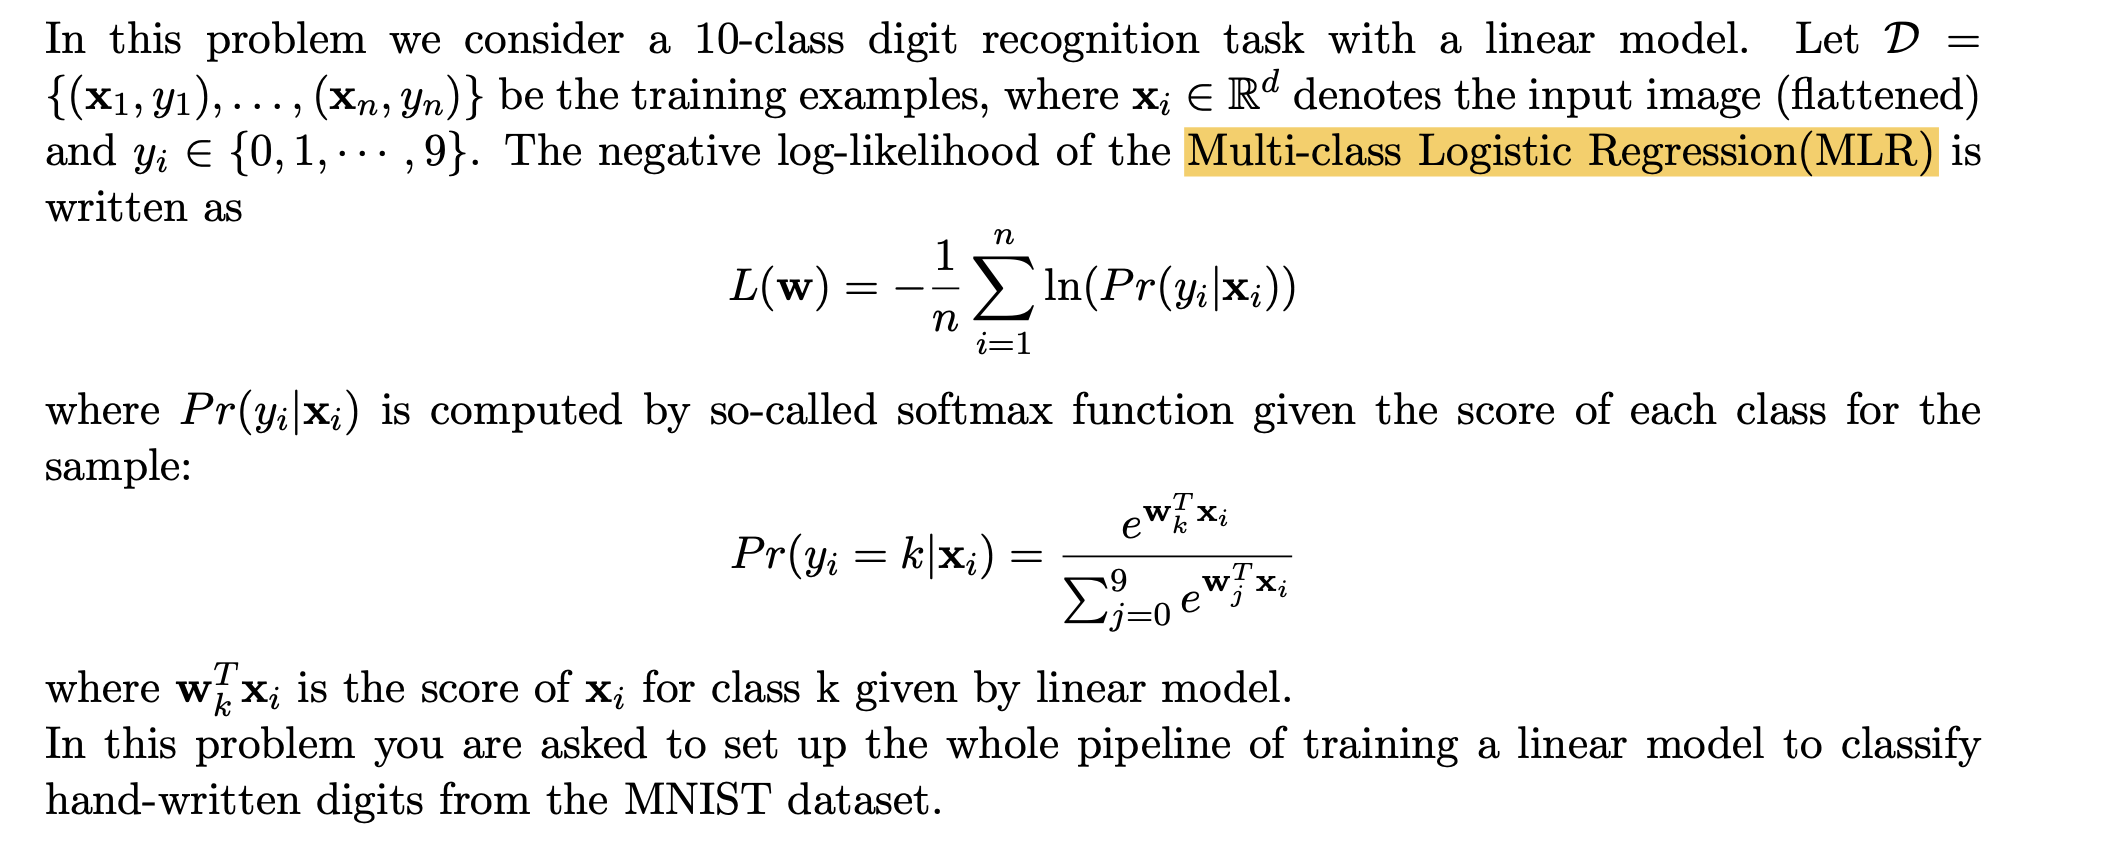

## 3(1) Data preprocessing

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Normalize images (Step 1b)
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1667, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)  # Ensure shapes are correct

(49998, 28, 28) (10002, 28, 28) (10000, 28, 28)


In [5]:
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0
X_test_normalized = X_test / 255.0

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import log_loss

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

# Define a simple logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

# Flatten the data
X_train_flat = X_train_normalized.reshape(-1, 28 * 28)
y_train = np.array(y_train)  # Ensure labels are in numpy array

# Convert data to PyTorch tensors and move them to the GPU if available
X_train_flat_tensor = torch.tensor(X_train_flat, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# List of batch sizes
batch_sizes = [1, 10, 100, 1000]

# Number of epochs
epochs = 20

# Storing results for each batch size
ce_losses_per_iteration = {}
ce_losses_per_epoch = {}

# Train the model for each batch size
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")

    # Initialize the model and move it to the GPU if available
    model = LogisticRegressionModel(input_size=28*28, num_classes=len(np.unique(y_train))).to(device)

    # Define the optimizer and loss function
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    n_iterations_per_epoch = len(X_train_flat) // batch_size
    total_iterations = n_iterations_per_epoch * epochs

    ce_loss_iterations = []
    ce_loss_epochs = []

    # Iterate through epochs
    for epoch in range(epochs):
        # Shuffle the data for each epoch
        indices = np.arange(len(X_train_flat))
        np.random.shuffle(indices)

        for i in range(0, len(X_train_flat), batch_size):
            # Extract the mini-batch
            batch_indices = indices[i:i + batch_size]
            X_batch = X_train_flat_tensor[batch_indices]
            y_batch = y_train_tensor[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)

            # Compute the loss
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Every 5000/batch_size iterations, compute CE loss
            if (i // batch_size + 1) % (5000 // batch_size) == 0:
                with torch.no_grad():
                    y_train_pred = model(X_train_flat_tensor).cpu()
                    ce_loss = log_loss(y_train, torch.softmax(y_train_pred, dim=1).numpy())
                    ce_loss_iterations.append(ce_loss)

        # At the end of each epoch, calculate CE loss for the entire training set
        with torch.no_grad():
            y_train_pred_epoch = model(X_train_flat_tensor).cpu()
            ce_loss_epoch = log_loss(y_train, torch.softmax(y_train_pred_epoch, dim=1).numpy())
            ce_loss_epochs.append(ce_loss_epoch)

    # Store losses for each batch size
    ce_losses_per_iteration[batch_size] = ce_loss_iterations
    ce_losses_per_epoch[batch_size] = ce_loss_epochs

# Now you have losses at every 5000/batch_size iterations and for each epoch


mps
Training with batch size: 1
Training with batch size: 10
Training with batch size: 100
Training with batch size: 1000


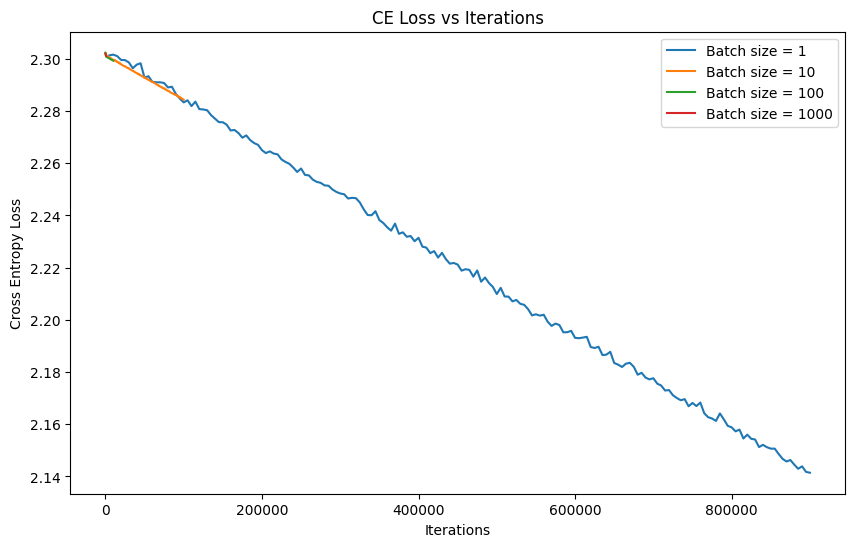

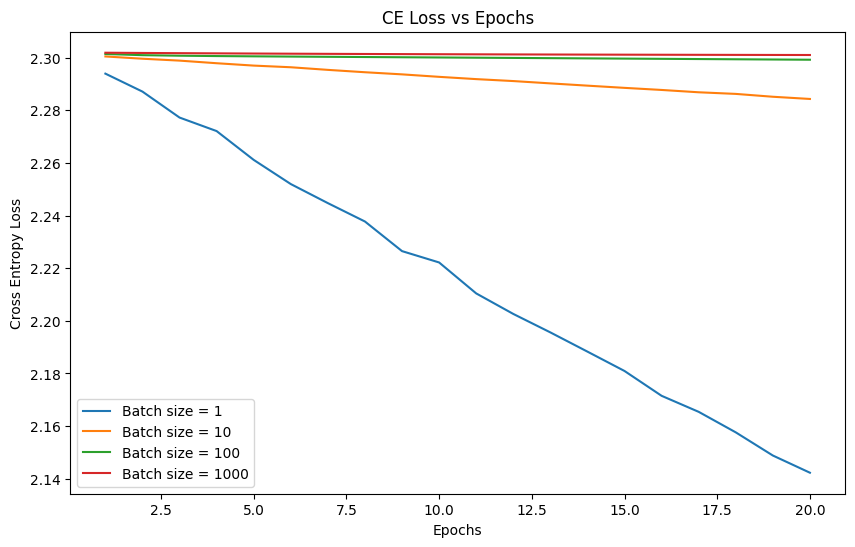

In [7]:
# Plot CE loss vs iterations
plt.figure(figsize=(10, 6))
for batch_size, losses in ce_losses_per_iteration.items():
    iterations = np.arange(1, len(losses) + 1) * (5000 // batch_size)
    plt.plot(iterations, losses, label=f'Batch size = {batch_size}')
    
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('CE Loss vs Iterations')
plt.legend()
plt.show()

# Plot CE loss vs epochs
plt.figure(figsize=(10, 6))
for batch_size, losses in ce_losses_per_epoch.items():
    epochs_range = np.arange(1, len(losses) + 1)
    plt.plot(epochs_range, losses, label=f'Batch size = {batch_size}')
    
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('CE Loss vs Epochs')
plt.legend()
plt.show()

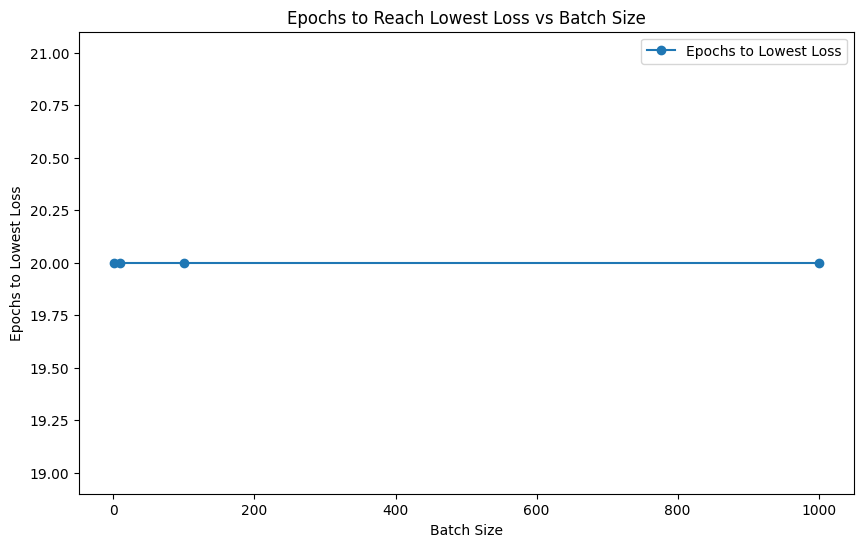

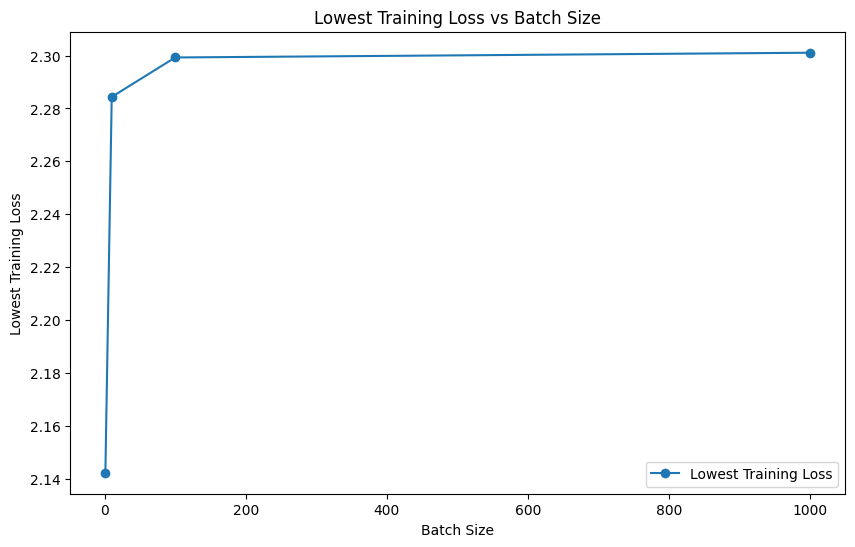

In [8]:
# Store results for number of epochs to lowest loss and the lowest loss achieved
epochs_to_lowest_loss = []
lowest_losses = []

for batch_size, losses in ce_losses_per_epoch.items():
    lowest_loss = min(losses)
    epoch_to_lowest_loss = losses.index(lowest_loss) + 1  # +1 because epoch indexing starts from 1
    epochs_to_lowest_loss.append(epoch_to_lowest_loss)
    lowest_losses.append(lowest_loss)

# Plot number of epochs to reach the lowest loss vs batch size
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, epochs_to_lowest_loss, marker='o', label='Epochs to Lowest Loss')
plt.xlabel('Batch Size')
plt.ylabel('Epochs to Lowest Loss')
plt.title('Epochs to Reach Lowest Loss vs Batch Size')
plt.legend()
plt.show()

# Plot lowest training loss vs batch size
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, lowest_losses, marker='o', label='Lowest Training Loss')
plt.xlabel('Batch Size')
plt.ylabel('Lowest Training Loss')
plt.title('Lowest Training Loss vs Batch Size')
plt.legend()
plt.show()
